This notebook simulates a statistical detector training and running during inference. The rolling or expanding score functions use past data to calculate the sum z scores for each sample. This is a test to see if it's worth generating a trace with intermittant adv samples.

In [5]:
import pandas as pd
import numpy as np
import plotly.figure_factory as ff
import seaborn as sns
import plotly.express as px
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay
from copy import deepcopy

In [6]:
def rolling_z_scores_dataset(df_clean, df_adv,adv_idx, win_len:int=1000):
    X = deepcopy(df_clean)
    X.iloc[adv_idx] = deepcopy(df_adv.iloc[adv_idx]) #inject adversarial samples
    y = np.ones(X.shape[0])
    y[adv_idx] = 0
    X = ((X - X.rolling(window=win_len).mean())/X.rolling(window=win_len).std()).abs().sum(axis='columns')
    X.replace([np.inf, -np.inf], np.nan, inplace=True)
    X.name = f'window_{win_len}_scores'

    return X, y

In [12]:
def cumulative_z_scores_dataset(df_clean, df_adv,adv_idx, min_samples:int=25):
    """returns the featureset X, which is the sum of the z scores for each sample
    calculated only use past data to compute the mean and std, and corresponding 
    labels where 0 is adversarial. """
    X = deepcopy(df_clean)
    X.iloc[adv_idx] = deepcopy(df_adv.iloc[adv_idx])
    
    #sum of the z scores of each sample, calculated using the cumulative mean and std generated from previous samples
    X = ((X - X.expanding(min_periods=min_samples).mean())/X.expanding(min_periods=min_samples).std()).abs().sum(axis='columns')
    
    X.replace([np.inf, -np.inf], np.nan, inplace=True) #just in case, min periods should avoid this
    X.name = f'cumulative_scores'

    y = np.ones(X.shape[0])
    y[adv_idx] = 0

    return X, y

In [7]:
df_baseline = pd.read_csv('baseline_obs.csv',
                          index_col=0)
df_adv = pd.read_csv('adv_perturbed_obs.csv',
                          index_col=0)

In [8]:
X, y = rolling_z_scores_dataset(df_baseline,df_adv, np.arange(2000,2100),1000)

In [9]:
px.line(X, x=X.index, y='window_1000_scores', color=y)

In [19]:
window = 850
start = 6390
n_adv = 100
X, y = rolling_z_scores_dataset(df_baseline,df_adv, np.arange(start,start+n_adv),window)
px.line(X, x=X.index, y=f'window_{window}_scores', color=y)

In [20]:
window = 850
start = 8246
n_adv = 100
X, y = rolling_z_scores_dataset(df_baseline,df_adv, np.arange(start,start+n_adv),window)
px.line(X, x=X.index, y=f'window_{window}_scores', color=y)

In [21]:
start = 6200
n_adv = 100
X, y = cumulative_z_scores_dataset(df_baseline,df_adv, np.arange(start,start+n_adv))
px.line(X, x=X.index, y=f'cumulative_scores', color=y)

In [22]:
start = 7900
n_adv = 100
X, y = cumulative_z_scores_dataset(df_baseline,df_adv, np.arange(start,start+n_adv))
px.line(X, x=X.index, y=f'cumulative_scores', color=y)

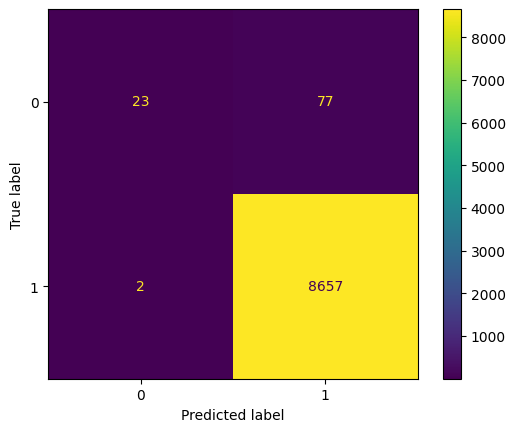

In [23]:
preds = X.apply(lambda x: 1 if x < 50 else 0)
ConfusionMatrixDisplay(confusion_matrix(y,preds)).plot()